/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_13160/3528234351.py:106: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, grid_predictions, levels=[0], linewidths=2, colors='purple', label='Decision Boundary')


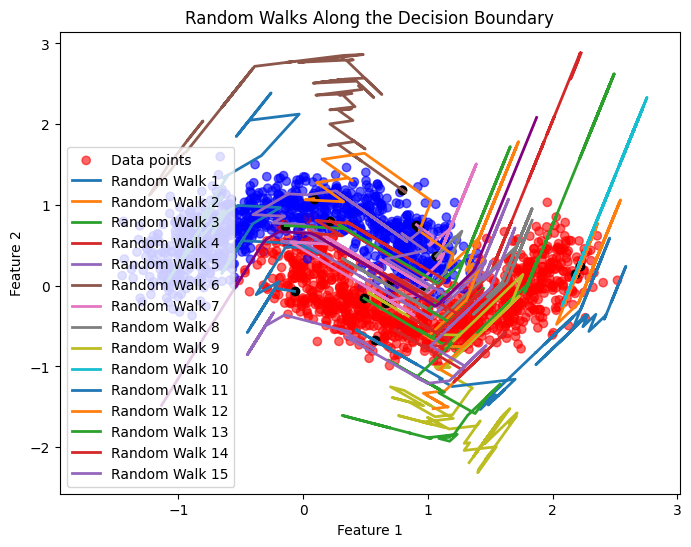

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch

# 1. Generate Sample Data
X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 2. Train a Simple Neural Network
model = torch.nn.Sequential(
    torch.nn.Linear(2, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

# 3. Find Multiple Initial Points on the Decision Boundary
def find_boundary_point(model, x_a, x_b, tol=1e-6):
    """ Find a point on the decision boundary between two points x_a and x_b. """
    while torch.norm(x_a - x_b) > tol:
        x_mid = (x_a + x_b) / 2.0
        f_mid = model(x_mid.unsqueeze(0)).item()
        if f_mid > 0:
            x_a = x_mid
        else:
            x_b = x_mid
    return x_mid

# Generate multiple pairs of points from different classes to find initial boundary points
initial_points = []
num_initial_points = 15  # Number of initial points to sample
for _ in range(num_initial_points):
    x_a = X[y == 0][torch.randint(len(X[y == 0]), (1,)).item()]
    x_b = X[y == 1][torch.randint(len(X[y == 1]), (1,)).item()]
    x0 = find_boundary_point(model, x_a, x_b)
    initial_points.append(x0)

# 4. Perform Parallel Random Walks Along the Decision Boundary
def random_walk_on_boundary(model, x0, num_steps=100, mu=0.1):
    x = x0.clone().detach().requires_grad_(True)
    path = [x.detach().numpy().copy()]
    
    for _ in range(num_steps):
        f_x = model(x.unsqueeze(0))
        f_x.backward()
        grad = x.grad.data
        
        # Sample eta from a 2D Gaussian with mean > 0
        eta = torch.normal(mean=torch.tensor([mu, mu]), std=torch.tensor([1, 1]))
        
        # Sample step size from a standard Gaussian distribution
        step_size = torch.randn(1).item()/5  # Corrected: using torch.randn to get a scalar from standard normal
        
        # Project eta onto the tangent space to keep on the boundary
        eta_proj = eta - (torch.dot(eta, grad) / grad.norm() ** 2) * grad
        
        # Update x in the direction of the projected vector with random step size
        x.data = x.data + step_size * eta_proj / eta_proj.norm()
        
        path.append(x.detach().numpy().copy())
        x.grad.zero_()
    
    return np.array(path)

# Run random walks for all initial points
paths = []
for x0 in initial_points:
    path = random_walk_on_boundary(model, x0)
    paths.append(path)

# 5. Visualize the Random Walks and the Decision Boundary
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, label='Data points')

# Plot the random walk paths
for i, path in enumerate(paths):
    plt.plot(path[:, 0], path[:, 1], linewidth=2, label=f'Random Walk {i+1}')
    plt.scatter(path[0, 0], path[0, 1], color='black')  # Mark the starting point

# Generate a grid of points
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Predict the output for each point in the grid
with torch.no_grad():
    grid_predictions = model(grid_tensor).numpy().reshape(xx.shape)

# Plot the decision boundary
plt.contour(xx, yy, grid_predictions, levels=[0], linewidths=2, colors='purple', label='Decision Boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Random Walks Along the Decision Boundary')
plt.show()
